- 1. 下载和缓存数据集

In [18]:
import os

import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import hashlib
import os
import tarfile
import zipfile

import pandas as pd
import requests
import torch

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

#@save
def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件"""
    assert name in DATA_HUB, f'{name} 不存在于 {DATA_HUB}'
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    filename = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(filename):
        sha1 = hashlib.sha1()
        with open(filename, 'rb') as f:
            while True:
                data = f.read(1024*1024)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return filename # 命中缓存, 存在同名的文件 且 文件的 sha1_hash 值一样

    print(f'正在从{url} 下载 {filename}')
    r = requests.get(url, stream=True, verify=True)
    with open(filename, 'wb') as f:
        f.write(r.content)
    return filename


# 下载并解压缩 zip 或 tar文件
#@save
def download_extract(name, folder=None):
    """下载并解压 tar/zip 文件"""
    filename = download(name)
    base_dir = os.path.dirname(filename)
    print('base_dir', base_dir)
    data_dir, ext = os.path.split(filename)
    print('data_dir', base_dir, ' ext ', ext)
    if ext == '.zip':
        fp = zipfile.ZipFile(filename, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(filename, 'r')
    else:
        assert False, '只有 zip/tar 文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

# 将测试 数据集 从 DATA_HUB 下载到本地
#@save
def download_all():
    """下载 DATA_HUB 中所有的数据集"""
    for name in DATA_HUB:
        download(name)

- 2. 访问和读取数据集

In [19]:
%matplotlib inline

kaggle_house_train = 'kaggle_house_train'
kaggle_hose_test = 'kaggle_house_test'

#@save
DATA_HUB[kaggle_house_train] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce'
)

#@save
DATA_HUB[kaggle_hose_test] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90'
)

train_data = pd.read_csv(download(kaggle_house_train))
test_data = pd.read_csv(download(kaggle_hose_test))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [20]:
# iloc: integer location(整数位置) , 基于行 和 列的整数位置来选择数据, 使用纯数字索引 而不是标签名称
print(train_data.iloc[0:4, [0,1,2,3,-3,-2,-1]]) # 访问前4行数据, 前4列+后3列数据

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [21]:
# 第一列是特征ID, 测试时不需要, 这里去掉
# train_data.iloc[:, 1:-1] 获取所有行记录, 然后去掉最后一列, 而 test_data.iloc[:, 1:] 是获取所有的行、列记录
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
# print(train_data.iloc[0:4, 0:4])
# print(train_data[0:4, 14]) # 不能这么访问

In [22]:
# print(train_data.SalePrice.values) # 查看销售价格
# print(all_features[:train_data.shape[0]].values)
# print(train_data.iloc[:, 1:])

- 3. 数据预处理 -- 标准化数据

通过将特征重新缩放到零均值和单位方差来标准化数据, 具体情况如下:<br>
使用公式标准化数据 $ x \leftarrow \frac {x-u}{\sigma}$
其中u是均值, σ是标准差 <br>
$E[x-u]=0$ <br>
$E[(x-u)^2] = E[x^2 -2xu + u^2]$ 其中 $x^2 = u^2 + \sigma^2 , E[x]=E[u]$, 所以左侧表达式可以转换为 $E[(x-u)^2] = E[(u^2 + \sigma^2) -2u^2 + u^2 ]=\sigma^2$

In [23]:
# 识别并提取所有数值型特征的列名
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x -x.mean())/x.std()) # 标准化数据, 数值特征减去均值, 除以标准差
all_features[numeric_features] = all_features[numeric_features].fillna(0) # 对NaN 数据填充为0, 如果是合法数据, 不做任何改动

In [24]:
# 使用独热编码方式 对数据进行处理, 比如: MSZoning 创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features = all_features.astype('float32') # 将数据类型转换为 float32, 如果不转换 原来数据时 bool, int64的数据, 后面转为 ndarray 使用 float32 会报错
print(all_features.shape)
print(all_features.dtypes.value_counts())

(2919, 330)
float32    330
Name: count, dtype: int64


In [25]:
import torch

# 通过values属性，从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练
n_train = train_data.shape[0]
# print('n_train ', n_train)
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# print('train_features ', train_features.shape)
# print('train_labels ', train_labels.shape)

- 4. 训练

下面定义的神经网络模型使用的线性模型是 $y = Xw + b, y_i = X_i w + b \ y_i 是标量$

In [26]:
from torch import nn

loss = nn.MSELoss()
in_features = train_features.shape[1] # shape[0] 记录条数, shape[1] 特征数

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1)) # y = Xw + b, y_i = X_i w + b y_i 是标量
    return net

- 考虑处理误差方式
房价、股票这种场景, 我们应该关心的是相对误差, 而不是绝对误差, 即考虑的是 $\frac {\hat{y} - y}{y}$, 而不是 $\hat{y} - y$
解决这个问题的方式
- 使用对数log来衡量


In [27]:
from d2l import torch as d2l

# torch.clamp() 是 PyTorch 中的一个重要函数，用于限制张量值的范围
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值, 将小于1的值设置为1
    clipped_preds = torch.clamp(input=net(features), min=1.0, max=float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels, num_epochs, leaning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    # print('train_features ', train_features, 'train_labels ', train_labels)
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(), lr=leaning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))  # 计算对数损失
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))

    return train_ls, test_ls

- 5. K折交叉验证

选择第 i 个切片作为验证数据，其余部分作为训练数据

In [28]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k # 数据量的记录数
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)

    return X_train, y_train, X_valid, y_valid

# 在k折交叉验证中训练k次后，返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, leaning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, leaning_rate, weight_decay, batch_size)

        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')

    return train_l_sum/k, valid_l_sum/k

- 6. 模型选择

In [29]:
k, num_epochs, lr, batch_size = 5, 100, 5, 64
# print('train_features ', train_features.shape)
# print('train_labels ', train_labels.shape)

折1，训练log rmse0.170112, 验证log rmse0.156123
折2，训练log rmse0.162165, 验证log rmse0.187594
折3，训练log rmse0.163592, 验证log rmse0.167928
折4，训练log rmse0.168239, 验证log rmse0.154966
折5，训练log rmse0.162803, 验证log rmse0.182795
Decay 0.0001: Train RMSE 0.1654, Valid RMSE 0.1699
折1，训练log rmse0.170916, 验证log rmse0.157056
折2，训练log rmse0.162510, 验证log rmse0.192754
折3，训练log rmse0.164099, 验证log rmse0.168122
折4，训练log rmse0.167352, 验证log rmse0.154451
折5，训练log rmse0.162848, 验证log rmse0.183077
Decay 1e-05: Train RMSE 0.1655, Valid RMSE 0.1711
折1，训练log rmse0.170115, 验证log rmse0.156768
折2，训练log rmse0.162640, 验证log rmse0.189963
折3，训练log rmse0.164327, 验证log rmse0.168665
折4，训练log rmse0.168132, 验证log rmse0.154683
折5，训练log rmse0.163227, 验证log rmse0.183035
Decay 1e-06: Train RMSE 0.1657, Valid RMSE 0.1706
最优衰减系数: 0.0001, 验证集RMSE: 0.1699


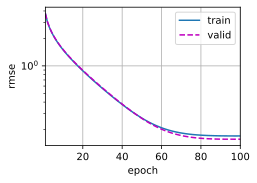

In [30]:
'''
查找最有权重衰减系数
'''
# 测试不同权重衰减系数
decay_values = [1e-4, 1e-5, 1e-6]
results = {}

for decay in decay_values:
    train_l, valid_l = k_fold(k, train_features, train_labels,
                            num_epochs, lr, decay, batch_size)
    results[decay] = (train_l, valid_l)
    print(f"Decay {decay}: Train RMSE {train_l:.4f}, Valid RMSE {valid_l:.4f}")

# 找出最佳衰减系数
best_decay = min(results, key=lambda x: results[x][1])
print(f"最优衰减系数: {best_decay}, 验证集RMSE: {results[best_decay][1]:.4f}")

折1，训练log rmse0.170445, 验证log rmse0.157044
折2，训练log rmse0.162066, 验证log rmse0.189446
折3，训练log rmse0.164572, 验证log rmse0.168639
折4，训练log rmse0.168353, 验证log rmse0.154603
折5，训练log rmse0.163652, 验证log rmse0.183006
5-折验证: 平均训练log rmse: 0.165818, 平均验证log rmse: 0.170548


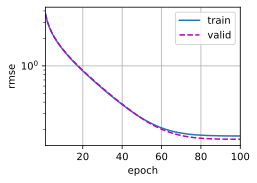

In [31]:
weight_decay = best_decay

train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

训练log rmse：0.162346


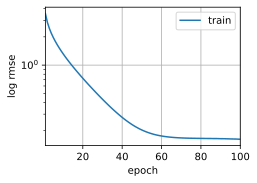

In [32]:
import numpy as np

def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], legend=['train'], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')

    # 将网络应用于测试集
    # 基于测试数据, 生成测试预测值
    preds = net(test_features).detach().numpy() # 这个是 [n, 1] 列向量数据, 而 pd.Series 需要 [1, n] 的数据, 所以下面在reshape 时转换成了, (1, -1)
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1) # 取 test_data 的 Id、SalePrice 两列, 按列进行合并
    submission.to_csv('../data/submission.csv', index=False)

num_epochs, lr, weight_decay, batch_size = 100, 5, 0, 64
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)